# AIS Port Classification notebook

This notebook is a walktrough of the AIS Marinetime Project by group 135. In this project, we have focused on Port Classification given time series data. 

The notebook consits of the following contents:
- [Introduction](#introduction-to-methods)
- [Setup](#setup) 
- [Data](#Data-exploration) 
    - [Data source & preparation](#data-sources--ingestion) 
    - [Descriptive statistics & Data Visualization](#descriptive-statistics)

# Introduction 

In this section, we will introduce the goal and methods in this project. We will present the different models and techniques used for port classification using AIS data. 

## The Goal of the Project 
The goal of this project is to build a model that can accurately classify ports based on AIS data. 
To achive this, we will have used 3 deep learning models and one simple machine learning model as a baseline. The models used are:  
1. LSTM - Long Short-Term Memory network 
2. Transformer
3. LSTM-Transformer Hybrid Model
4. "TO DO " (baseline) 


For each model, the output is from a feed forward neural network with can be toughts of as logits. 

We use the cross-entropy loss function to train the models, as it is well suited for multi-class classification problems. 



# Setup

Before running this notebook, make sure to install the required dependencies listed in the `pyproject.toml` file and have access to the dataset used in this project.

This project uses `uv` as the Python package manager. All dependencies are defined in `pyproject.toml`.

Run the following commands to set up your environment:

```bash
# Install all dependencies from pyproject.toml
uv sync

# Install the project in editable mode (to import from src/)
uv pip install -e .
```

The cleaned dataset used in this project can be found here: [https://drive.google.com/drive/folders/1o17rqpOwHRdrgkoRS8rd5g62xi9nsTuk?hl=da] 

The folder is called "processed_data" and should be zipped and placed in the data directory of this project.

Otherwise, you can down the data in the next cell. 



In [5]:
import matplotlib.pyplot as plt
import pandas as pd 
from Dataloader import Dataloader 
import numpy as np 
import torch 


In [6]:
config = {
    "DOWNLOAD_DATA": False, 
    
    "TRAIN_OWN_MODEL": False, 

    "LOAD_PRETRAINED_MODEL": True,

    "OS": "macOS",

    "DATA_PATH": "data/processed_data"
}



hyperparameters = {
}

#Setting seed for reproducibility 
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)  

# Data

## Data source & Preparation 

If you wish to download the cleaned dataset used in this project directly from the source, please refer to the prepare_data.ipynb. 


All the data is being prerocessed and cleaned in the prepare_data.ipynb notebook.

We do the following steps in the data preparation:
1. Download 2023 raw data from [AIS data source](http://aisdata.ais.dk/)
2. We only keep the column that we deem are relevant for our project i.e 
    - MMSI
    - SOG 
    - COG
    - Longitude
    - Latitude
    - Timestamp 
    - Ship type 
    - Type of mobile  
    - Length 
    - Width 
    - Destination 

3. We filter the following data points: 
    - data points not in the Danish waters. 
    - data points which are classfied as "Ship type A" and then remove all other ship types. (Type of mobile is redundant after this step and removed).  
    - 1 <= SOG <= 50 knots 
    - Sequences below 250 data points are removed. 
    - data with non-valid port codes are removed (/data_port_locodes.csv are used a source of truth)
    - Filter anomalities where the contains jump in data points that are not realistic (based on SOG and distance between points). 


4. We do the following transformations:
    - Label the data points for each date into segments
    - Datapoints are concated based on segments such that each sequence of a ship can stretch over multiple days. 
    - downsampling such that there is at least 10 seconds between each data point (if two points are closer than 10 seconds, we remove the first point). 




In [7]:
import pandas as pd 
from Dataloader import Dataloader 
import matplotlib.pyplot as plt

path = config["DATA_PATH"]
dataloader = Dataloader(out_path=path)
df = dataloader.load_data()  # load all files in the processed_data folder

Loading aisdk-2023-07-03.parquet...
Loading aisdk-2023-07-13.parquet...
Loading aisdk-2023-05-26.parquet...
Loading aisdk-2023-09-16.parquet...
Loading aisdk-2023-09-06.parquet...
Loading aisdk-2023-02-12.parquet...
Loading aisdk-2023-11-01.parquet...
Loading aisdk-2023-02-02.parquet...
Loading aisdk-2023-11-11.parquet...
Loading aisdk-2023-10-28.parquet...
Loading aisdk-2023-08-10.parquet...
Loading aisdk-2023-09-29.parquet...
Loading aisdk-2023-05-09.parquet...
Loading aisdk-2023-05-19.parquet...
Loading aisdk-2023-06-05.parquet...
Loading aisdk-2023-06-15.parquet...
Loading aisdk-2023-04-30.parquet...
Loading aisdk-2023-02-12.parquet...
Loading aisdk-2023-11-01.parquet...
Loading aisdk-2023-02-02.parquet...
Loading aisdk-2023-11-11.parquet...
Loading aisdk-2023-10-28.parquet...
Loading aisdk-2023-08-10.parquet...
Loading aisdk-2023-09-29.parquet...
Loading aisdk-2023-05-09.parquet...
Loading aisdk-2023-05-19.parquet...
Loading aisdk-2023-06-05.parquet...
Loading aisdk-2023-06-15.par

------------------- RANDOM EDITS BELOW -------------------

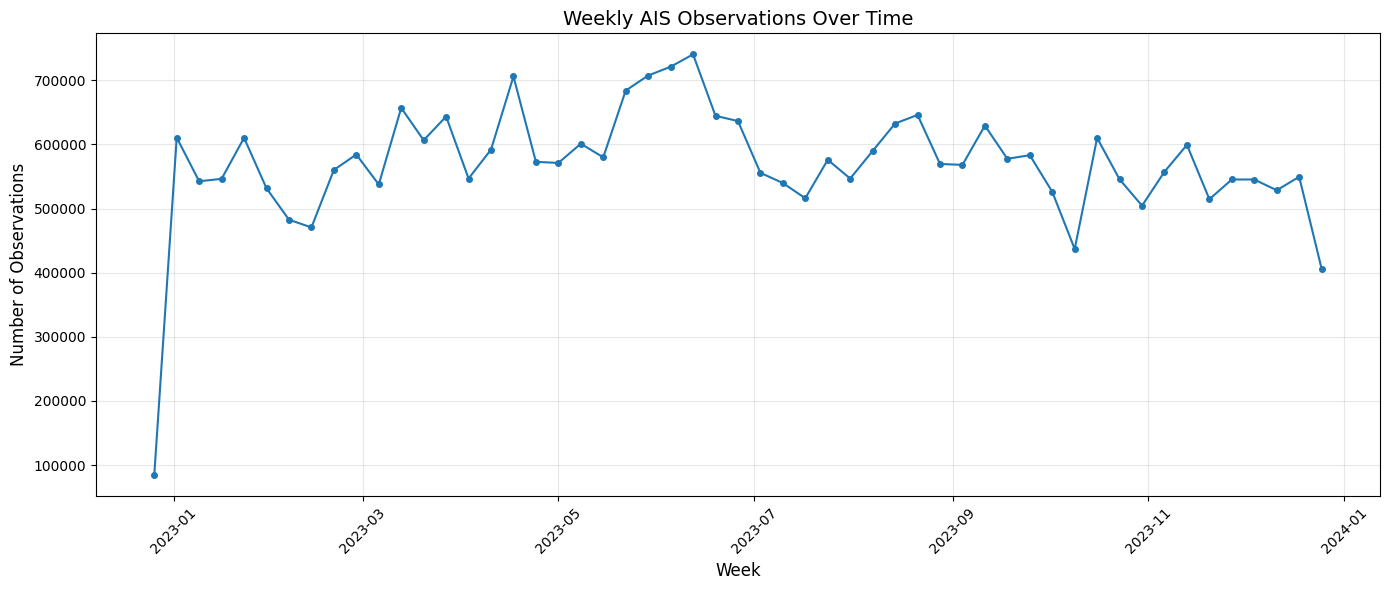

Total weeks: 53
Total observations: 30,169,293
Average observations per week: 569232
Min observations in a week: 84,544
Max observations in a week: 740,347


In [18]:
import matplotlib.pyplot as plt

def plot_daily_observations(df, timestamp_col="Timestamp"):
    """
    Groups dataframe by week, counts observations, and plots the time series.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the data
    timestamp_col : str
        Name of the timestamp column (default: "Timestamp")
    
    Returns:
    --------
    pd.Series
        Weekly observation counts indexed by week start date
    """
    # Convert to datetime if not already
    df_copy = df.copy()
    df_copy[timestamp_col] = pd.to_datetime(df_copy[timestamp_col])
    
    # Extract year-week and count observations per week
    df_copy['YearWeek'] = df_copy[timestamp_col].dt.to_period('W')
    weekly_counts = df_copy['YearWeek'].value_counts().sort_index()
    
    # Convert index to datetime for better plotting (use first day of each week)
    weekly_counts.index = weekly_counts.index.to_timestamp()
    
    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(weekly_counts.index, weekly_counts.values, marker='o', linewidth=1.5, markersize=4)
    plt.xlabel('Week', fontsize=12)
    plt.ylabel('Number of Observations', fontsize=12)
    plt.title('Weekly AIS Observations Over Time', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Total weeks: {len(weekly_counts)}")
    print(f"Total observations: {weekly_counts.sum():,}")
    print(f"Average observations per week: {weekly_counts.mean():.0f}")
    print(f"Min observations in a week: {weekly_counts.min():,}")
    print(f"Max observations in a week: {weekly_counts.max():,}")
    
    return weekly_counts

# Use the function
daily_obs = plot_daily_observations(df)

In [19]:
df

,Timestamp,Latitude,Longitude,SOG,COG,Ship type,Width,Length,Destination,MMSI,Segment
0,2023-07-03 00:03:17,57.688542,10.687978,0.154333,268.7,Tanker,16.0,96.0,DKSKA,205771000,1
1,2023-07-03 00:03:46,57.688905,10.687737,0.411555,359.9,Tanker,16.0,96.0,DKSKA,205771000,1
2,2023-07-03 00:06:46,57.689548,10.687770,0.000000,22.5,Tanker,16.0,96.0,DKSKA,205771000,1
3,2023-07-03 00:09:17,57.689548,10.687770,0.000000,22.5,Tanker,16.0,96.0,DKSKA,205771000,1
4,2023-07-03 00:09:46,57.688953,10.688295,0.463000,156.2,Tanker,16.0,96.0,DKSKA,205771000,1
...,...,...,...,...,...,...,...,...,...,...,...
30169288,2023-11-04 02:47:26,55.213132,5.605917,4.681440,217.9,Cargo,46.0,300.0,DEHAM,636092784,2
30169289,2023-11-04 02:47:36,55.212813,5.605447,4.681440,218.7,Cargo,46.0,300.0,DEHAM,636092784,2
30169290,2023-11-04 02:50:35,55.206907,5.597563,4.527107,210.9,Cargo,46.0,300.0,DEHAM,636092784,2
30169291,2023-11-04 02:50:56,55.206187,5.596842,4.527107,209.9,Cargo,46.0,300.0,DEHAM,636092784,2


# Loading models and data

## Loading run 

In [ ]:


client = MlflowClient()            # or MlflowClient(tracking_uri)
experiment_id = "964646345580301318"

exp = MlflowClient().get_experiment(experiment_id) 
runs = MlflowClient().search_runs(experiment_id)


/Users/madshaakonsson/Desktop/DL/marinetime-project/.venv/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


In [8]:
runs

[<Run: data=<RunData: metrics={'train_accuracy': 26.62058371735791,
  'train_loss': 4.290283488016652,
  'val_accuracy': 27.129375223987577,
  'val_loss': 3.9166969579594735}, params={'batch_first': 'True',
  'batch_size': '16',
  'dropout': '0.2',
  'hidden_size': '64',
  'learning_rate': '0.001',
  'num_epochs': '30',
  'num_heads': '8',
  'num_lstm_layers': '2',
  'num_transformer_layers': '2',
  'train_split': '0.7'}, tags={'mlflow.runName': 'tasteful-quail-732',
  'mlflow.source.git.commit': 'cb545cdb185192cc5d61d5e2f4576ebcf283c878',
  'mlflow.source.name': 'src/train_lstm_transformer.py',
  'mlflow.source.type': 'LOCAL',
  'mlflow.user': 'madshaakonsson'}>, info=<RunInfo: artifact_uri='file:///Users/madshaakonsson/Desktop/DL/marinetime-project/mlruns/964646345580301318/b46274b09b2e4058a304c7916029664d/artifacts', end_time=1764061447338, experiment_id='964646345580301318', lifecycle_stage='active', run_id='b46274b09b2e4058a304c7916029664d', run_name='tasteful-quail-732', start_ti